In [442]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import math
from scipy.stats import chi2
import pandas as pd

plt.style.use(hep.style.CMS)


In [443]:
folder = "C:/Users/phili/Desktop/Studium/6.Semester/Semesterarbeit/dataset"

df_target = ak.from_parquet(folder+'/ttHTobb_2018_test.parquet')
df_metrics_metrics_metrics_eft_tbarlnutqq = ak.from_parquet(folder+'/ttHTobb_EFT_tbarlnutqq_2018_test.parquet')
df_eft_tbarqqtlnu = ak.from_parquet(folder+'/ttHTobb_EFT_tbarqqtlnu_2018_test.parquet')

df_eft = ak.concatenate([df_eft_tbarlnutqq, df_eft_tbarqqtlnu])

def reweight(weights_eft, weights_target):
    weights_eft.to_numpy(); weights_target.to_numpy()
    
    A = np.sum(weights_target)/np.sum(weights_eft)
        
    return A, A*weights_eft

weights_eft = df_eft.weight
weights_target = df_target.weight

A, weights_eft = reweight(weights_eft, weights_target)
df_eft = ak.with_field(df_eft, weights_eft, "weight")


print("K-factor: ", A)
"""
plt.hist(rw_weights_eft, bins=100, label="Reweighted weights EFT")
plt.hist(weights_target, bins=100, label="Reweighted weights Target")
plt.legend()
plt.show()
"""

K-factor:  0.7826885718054716


'\nplt.hist(rw_weights_eft, bins=100, label="Reweighted weights EFT")\nplt.hist(weights_target, bins=100, label="Reweighted weights Target")\nplt.legend()\nplt.show()\n'

In [ ]:

def standardize_feature(col: np.ndarray, transform: str = None):
    """
    Apply optional transform to col, then z-score:
      - transform="log1p": replace col -> log(col + 1)
      - transform=None: leave col as is
    Returns the transformed, zero-mean, unit-std array.
    """
    # 1) optional transform
    if transform == "log1p":
        col = np.log(col + 1)
    # 2) compute mean & std
    mu = np.mean(col)
    sigma = np.std(col)
    # 3) z-score
    return (col - mu) / (sigma if sigma != 0 else 1.0)

def build_X_and_standardize(df_combined, objects, fields, orders):
    """
    Pull out raw arrays, standardize each (pt->log1p+z, eta->z, phi->z),
    and stack into an (N, D) array.
    """
    X_cols = []
    for obj in objects:
        for field in fields:
            for order in orders:
                # extract a 1d numpy array
                raw = getattr(getattr(df_combined, obj), field)[:, order].to_numpy()
                # pick transform type
                if field == "pt":
                    col = standardize_feature(raw, transform="log1p")
                else:
                    col = standardize_feature(raw, transform=None)
                X_cols.append(col)
    # stack into (n_events, n_features)
    return np.stack(X_cols, axis=1)

# ——————————————————————————————
# usage:

n_epochs = 30  # adjust as needed
hidden_dim = 64  # hidden layer size
batch_size = 2048  # adjust as needed
learning_rate = 1e-3  # adjust as needed
channels = 20
prior_width = 1.

# 1) label & concat as before
df_target["label"] = 1
df_eft   ["label"] = 0
df_combined = ak.concatenate([df_target, df_eft])

# 2) define your objects/fields/orders
objects = ["top", "antitop", "lepton_gen", "lepton_reco", "higgs"]
fields  = ["pt", "eta", "phi"]
orders  = [0]
length_features = len(objects)*len(fields)*len(orders)

# 3) build standardized X
X = build_X_and_standardize(df_combined, objects, fields, orders)
y = df_combined.label.to_numpy()
w = df_combined.weight.to_numpy()

# 4) to torch 
X_torch = torch.tensor(X, dtype=torch.float32).expand(channels,-1,-1)#.to("cuda")
y_torch = torch.tensor(y, dtype=torch.float32).expand(channels,-1).unsqueeze(-1)#.to("cuda")
w_torch = torch.tensor(w, dtype=torch.float32).expand(channels,-1).unsqueeze(-1)#.to("cuda")

print(X_torch.shape, y_torch.shape, w_torch.shape)

torch.Size([20, 943341, 15]) torch.Size([20, 943341, 1]) torch.Size([20, 943341, 1])


In [445]:
# Initialize a Comet experiment
experiment = Experiment(
    api_key="s0G6qTP8E4YpcrewlNfry98cY",
    project_name="ttHbb-reweighting",
    workspace="philiw"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/philiw/tthbb-reweighting/5aa180d7840f41e59a9c9c90364f06cd



In [446]:
class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [447]:
# Log hyperparameters
experiment.log_parameters({
    "input_dim": length_features,
    "hidden_dim": hidden_dim,
    "channels": channels,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs
})


n_events = len(X)
all_idx = np.arange(n_events)

idx_train, idx_test = train_test_split(all_idx, test_size=0.5, random_state=42) # Optional: stratify

# keep  convenience copy that contains ONLY the EFT rows inside the train fold
eft_train_idx = idx_train[y[idx_train] == 0]
target_train_idx = idx_train[y[idx_train] == 1]
eft_test_idx = idx_test[y[idx_test] == 0]
target_test_idx = idx_test[y[idx_test] == 1]

X_train = X_torch[:,idx_train]
y_train = y_torch[:,idx_train]
w_train = w_torch[:,idx_train]

X_test = X_torch[:,idx_test]
y_test = y_torch[:,idx_test]
w_test = w_torch[:,idx_test]

# 2. Build train and test datasets
train_dataset = TensorDataset(X_train, y_train, w_train)
test_dataset  = TensorDataset(X_test,  y_test,  w_test)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 4. (Optional) Log sizes
experiment.log_metric("train_size", len(train_dataset))
experiment.log_metric("test_size",  len(test_dataset))

model = nn.Sequential(
    StackedLinear(length_features, hidden_dim, channels),
    nn.ReLU(),
    StackedLinear(hidden_dim, hidden_dim, channels),
    nn.ReLU(),
    StackedLinear(hidden_dim, 1, channels),
)#.to("cuda")

n_batches = len(train_loader)

loss_fn = nn.BCEWithLogitsLoss(reduction="none")
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1 / (2*len(X)*prior_width**2))
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, n_epochs*n_batches)

In [448]:
def evaluate_model_on_eft(model, X, y, w):
    """
    X: Tensor of shape (channels, n_events, n_features)
    y: Tensor of shape (channels, n_events, 1) — same labels in each channel
    w: Tensor of shape (channels, n_events, 1) — same MC weights in each channel

    Returns three tensors, each of shape (channels, n_eft_events):
      f_eft               — sigmoid(model) on EFT events, per channel
      reweighted_wts      — original MC weights * w(x), per channel
      reweighting_factors — w(x)=f/(1-f), per channel
    """
    model.eval()

    # 1) remove the singleton label/weight dim -> (channels, n_events)
    y_all    = y.squeeze(-1).cpu().numpy()
    w_mc_all = w.squeeze(-1).cpu().numpy()

    # 2) build mask for EFT events (use channel 0 since labels are identical across channels)
    eft_mask = (y_all[0] == 0)    # shape (n_events,)

    with torch.no_grad():
        # 3) forward pass: logits (channels, n_events, 1) -> squeeze -> (channels, n_events)
        logits = model(X).squeeze(-1)
        f_all  = torch.sigmoid(logits).cpu().numpy()             # f(x), shape (channels, n_events)
        w_new  = f_all / (1.0 - f_all)              # reweight factors, same shape

    # 4) mask off only the EFT events along the event-dimension
    f_eft               = f_all[:,    eft_mask]  # (channels, n_eft)
    reweighting_factors = w_new[:,    eft_mask]  # (channels, n_eft)
    reweighted_wts      = w_mc_all[:, eft_mask] * reweighting_factors

    return f_eft, reweighted_wts, reweighting_factors
 
def plot_dist_f(f_eft, eft_indices = None, epoch=-1):
    masked_weights_eft = df_combined.weight[eft_indices].to_numpy()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(f_eft, bins=50, weights=masked_weights_eft)
    ax.set_xlabel("f(x)")
    ax.set_ylabel("Weighted Events")
    filename = f"distribution_f.png"
    #plt.show()  # Optionally, you can omit this in non-interactive scripts
    if epoch == -1:
        plt.savefig(filename)
        experiment.log_image(filename, name=filename)
    else:
        plt.savefig(filename)
        experiment.log_image(filename, name=filename, step=epoch)
    plt.close(fig)

def plot_dist_w(reweighting_factors, eft_indices = None, epoch=-1):
    masked_weights_eft = df_combined.weight[eft_indices].to_numpy()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(reweighting_factors, bins=50, weights=masked_weights_eft)
    ax.set_xlabel("w(x)")
    ax.set_ylabel("Weighted Events")
    filename = f"distribution_w.png"
    #plt.show()  # Optionally, you can omit this in non-interactive scripts
    if epoch == -1:
        plt.savefig(filename)
        experiment.log_image(filename, name=filename)
    else:
        plt.savefig(filename)
        experiment.log_image(filename, name=filename, step=epoch)
    plt.close(fig)

def get_bins_and_scale(object, field, num_bins=50):
    if field == 'pt':
        if object == 'top' or object == 'antitop':
            return np.logspace(1.2, 2.9, num_bins), 'log'
        if object == 'higgs':
            return np.logspace(0.8, 2.9, num_bins), 'log'
        if object == 'lepton_gen' or object == 'lepton_reco':
            return np.logspace(1.35, 2.65, num_bins), 'log'
    elif field == 'eta':
        if object == 'lepton_gen' or object == 'lepton_reco':
            return np.linspace(-2.6, 2.6, num_bins), 'linear'
        else:
            return np.linspace(-4, 4, num_bins), 'linear'
    elif field == 'phi':
        return np.linspace(-np.pi, np.pi, num_bins), 'linear'
    else:
        raise ValueError(f"Unknown field: {field}")
    
def chi2_test(data_counts, model_counts, data_unc=None, model_unc=None):
    """
    Compute a chi^2 statistic comparing two binned histograms.
    data_counts: 1D array of bin counts from target data
    model_counts: 1D array of bin counts from your model (e.g. reweighted EFT)
    
    Returns:
        chi2_val: the sum of (data - model)^2 / (sigma^2)
        ndof: degrees of freedom (naive = number of nonempty bins - 1)
        p_value: the p-value for that chi^2 and ndof
    """
    data_counts = np.ravel(data_counts)
    model_counts = np.ravel(model_counts)
    
    # If uncertainties are not provided, assume Poisson errors
    if data_unc is None:
        data_unc = np.sqrt(data_counts)
    else:
        data_unc = np.ravel(data_unc)
    if model_unc is None:
        model_unc = np.sqrt(model_counts)
    else:
        model_unc = np.ravel(model_unc)

    total_unc_sq = data_unc**2 + model_unc**2

    mask = total_unc_sq > 0
    
    chi2_val = np.sum((data_counts[mask] - model_counts[mask])**2 / total_unc_sq[mask])
    ndof = np.sum(mask) - 1  # naive degrees of freedom
    p_value = 1.0 - chi2.cdf(chi2_val, ndof)
    return chi2_val/ndof, ndof, p_value

def visualize_chi2_results(df_metrics, epoch=-1):
    # Create a label for each combination
    df_metrics['label'] = df_metrics['object'] + '.' + df_metrics['field'] + '.order' + df_metrics['order'].astype(str)

    # Set up the bar plot
    x = np.arange(len(df_metrics))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(x - width/2, df_metrics['chi2_unweighted'], width, label='Unweighted')
    ax.bar(x + width/2, df_metrics['chi2_reweighted'], width, label='Reweighted')

    # Labeling
    ax.set_xticks(x)
    ax.set_xticklabels(df_metrics['label'], rotation=45, ha='right')
    ax.set_ylabel('Chi-squared')
    ax.set_title('Comparison of Unweighted vs Reweighted Chi-squared Values')
    ax.legend()

    plt.tight_layout()

    # Save & log figures
    filename = f"chi2_results.png"
    plt.savefig(filename)
    plt.close()
    if epoch == -1:
        experiment.log_image(filename, name=filename)

def plot_1d_dist(reweighted_wts, std_devs, eft_indices=None, target_indices = None, epoch=-1): #Default select all events in 
    metrics = []
    
    for obj in objects:
        for field in fields:

            bins, scale = get_bins_and_scale(obj, field)
            
            for order in orders:
                # Extract the appropriate variable from the EFT and Target data, select indices based on what the model evaluated on
                eft_variable = getattr(getattr(df_combined, obj), field)[:, order][eft_indices].to_numpy()
                target_variable = getattr(getattr(df_combined, obj), field)[:, order][target_indices].to_numpy()
                masked_weights_eft = df_combined.weight[eft_indices].to_numpy()
                masked_weights_target = df_combined.weight[target_indices].to_numpy()

                # Define your histogram bins (you may wish to adjust these per variable)
                bin_centers = 0.5 * (bins[1:] + bins[:-1])

                # Compute the histograms
                hist_eft, _    = np.histogram(eft_variable, bins=bins, weights=masked_weights_eft)
                hist_rw_eft, _ = np.histogram(eft_variable, bins=bins, weights=reweighted_wts)
                hist_rw_eft_up, _ = np.histogram(eft_variable, bins=bins, weights=reweighted_wts + std_devs)
                hist_rw_eft_down, _ = np.histogram(eft_variable, bins=bins, weights=reweighted_wts - std_devs)
                hist_target, _ = np.histogram(target_variable, bins=bins, weights=masked_weights_target)

                # Calculate errors for the histograms
                errors_target_sqrd, _ = np.histogram(target_variable, bins=bins, weights=masked_weights_target**2)
                errors_target = np.sqrt(errors_target_sqrd)
                errors_eft_sqrd, _ = np.histogram(eft_variable, bins=bins, weights=masked_weights_eft**2)
                errors_eft = np.sqrt(errors_eft_sqrd)
                errors_rwt = np.abs(hist_rw_eft_up - hist_rw_eft_down)/2


                # Create the figure with a top and bottom panel
                fig, (ax_top, ax_bot) = plt.subplots(
                    2, 1, figsize=(10, 10),
                    gridspec_kw={'height_ratios': [5, 2]}
                )
                
                # Top panel: draw the histograms
                ax_top.stairs(hist_eft, bins, label="EFT data", fill=False)
                ax_top.stairs(hist_rw_eft, bins, label=f"Reweighted EFT", fill=False)
                ax_top.stairs(hist_target, bins, label="Target data", fill=False)
                ax_top.fill_between(
                    bins[:-1], hist_rw_eft_down, hist_rw_eft_up,
                    step='post', alpha=0.5, label='RE Uncertainty',
                )
                ax_top.set_xscale(scale)
                ax_top.set_xlabel(f"{obj}.{field}")
                ax_top.set_ylabel("Weighted events")
                ax_top.set_title(f"Histogram of {obj}.{field}, order: {order}")
                ax_top.legend()

                # Bottom panel: compute and plot the ratios
                # Ratio of target to original EFT
                ratio_old = np.where(hist_eft != 0, hist_target / hist_eft, np.nan)
                # Ratio of target to reweighted EFT
                ratio_rw = np.where(hist_rw_eft != 0, hist_target / hist_rw_eft, np.nan)
                ratio_rw_up = np.where(hist_rw_eft_up != 0, hist_target / hist_rw_eft_up, np.nan)
                ratio_rw_down = np.where(hist_rw_eft_down != 0, hist_target / hist_rw_eft_down, np.nan)

                ax_bot.plot(bin_centers, ratio_old, 'o-', label="Original ratio", markersize=3)
                ax_bot.plot(bin_centers, ratio_rw, 'o-', label=f"Reweighted ratio", markersize=3)
                ax_bot.fill_between(
                    bin_centers, ratio_rw_down, ratio_rw_up,
                    alpha=0.5, label='Propagated RE uncertainty',
                )
                ax_bot.set_xscale(scale)
                ax_bot.axhline(1.0, color='gray', linestyle='--')
                ax_bot.set_ylim(0.5, 1.5)
                ax_bot.set_ylabel("Target / EFT")
                ax_bot.set_xlabel(f"{obj}.{field}")
                ax_bot.legend(fontsize=10)

                plt.tight_layout()
                
                # Save & log figures
                filename = f"1d_reweighting_{obj}_{field}_{order}.png"
                plt.savefig(filename)
                if epoch == -1:
                    experiment.log_image(filename, name=filename)
                else:
                    experiment.log_image(filename, name=filename, step=epoch)
                plt.close()

                if epoch == -1:
                    # Run your chi² tests
                    chi2_unw, ndof_unw, p_unw = chi2_test(hist_eft,    hist_target, errors_eft,    errors_target)
                    chi2_nom, ndof_nom, p_nom = chi2_test(hist_rw_eft, hist_target, errors_rwt,    errors_target)

                    # Append this row’s results
                    metrics.append({
                        "object":                obj,
                        "field":                 field,
                        "order":                 order,
                        "chi2_unweighted":       chi2_unw,
                        "ndof_unweighted":       ndof_unw,
                        "pval_unweighted":       p_unw,
                        "chi2_reweighted":       chi2_nom,
                        "ndof_reweighted":       ndof_nom,
                        "pval_reweighted":       p_nom,
                    })

    if epoch == -1:
        # After exiting all loops: build a DataFrame and log it
        df_metrics = pd.DataFrame(metrics)

        csv_name = "chi2_test_summary_1d.csv"
        experiment.log_table(
            filename=csv_name,
            tabular_data=df_metrics,
        )

        visualize_chi2_results(df_metrics, epoch=epoch)

def plot_2d_dist(reweighted_wts, std_devs, eft_indices=None, target_indices = None, epoch=-1):
    metrics = []
    
    for i, obj1 in enumerate(objects):
        for j, obj2 in enumerate(objects):
            if i >= j:
                continue
            for field1 in fields:
                for field2 in fields:
                    for order in orders:
                        # get bins for the 2D histogram
                        bins1, scale1 = get_bins_and_scale(obj1, field1, num_bins=20)
                        bins2, scale2 = get_bins_and_scale(obj2, field2, num_bins=20)

                        # extract EFT phase‐space coords
                        eft_x = getattr(getattr(df_combined, obj1), field1)[:, order][eft_indices].to_numpy()
                        eft_y = getattr(getattr(df_combined, obj2), field2)[:, order][eft_indices].to_numpy()
                        target_x = getattr(getattr(df_combined, obj1), field1)[:, order][target_indices].to_numpy()
                        target_y = getattr(getattr(df_combined, obj2), field2)[:, order][target_indices].to_numpy()
                        masked_weights_eft = df_combined.weight[eft_indices]
                        masked_weights_target = df_combined.weight[target_indices]
                        
                        # 5) make figure with one subplot per bin

                        fig, axs = plt.subplots(1, 4, figsize=(32, 8))

                        h_eft_result = axs[0].hist2d(
                            eft_x, eft_y, bins=[bins1, bins2],
                            weights=masked_weights_eft.to_numpy(), cmap='inferno'  
                        )
                        axs[0].set_xscale(scale1)
                        axs[0].set_yscale(scale2)
                        axs[0].set_title("EFT (unweighted)")
                        axs[0].set_xlabel(f"{obj1}-{field1}")
                        axs[0].set_ylabel(f"{obj2}-{field2}")
                        plt.colorbar(h_eft_result[3], ax=axs[0])
                        
                        # Reweighted EFT 2D histogram
                        h_rew_result = axs[1].hist2d(
                            eft_x, eft_y, bins=[bins1, bins2],
                            weights=reweighted_wts, cmap='inferno'
                        )
                        axs[1].set_xscale(scale1)
                        axs[1].set_yscale(scale2)
                        axs[1].set_title("Reweighted EFT")
                        axs[1].set_xlabel(f"{obj1}-{field1}")
                        axs[1].set_ylabel(f"{obj2}-{field2}")
                        plt.colorbar(h_rew_result[3], ax=axs[1])
                        
                        # Target 2D histogram
                        h_target_2d = np.histogram2d(
                            target_x, target_y, bins=[bins1, bins2],
                            weights=masked_weights_target.to_numpy()
                        )[0]
                        
                        # 2D ratio: target / EFT (original)
                        ratio_original = np.where(h_eft_result[0] != 0, h_target_2d / h_eft_result[0], np.nan)
                        h3 = axs[2].pcolormesh(
                            bins1, 
                            bins2, 
                            ratio_original.T,  # note transpose
                            cmap='inferno',
                            vmin=0.5,
                            vmax=1.5,
                            shading='auto'
                        )
                        axs[2].set_xscale(scale1)
                        axs[2].set_yscale(scale2)
                        axs[2].set_title("Ratio: Target / EFT")
                        axs[2].set_xlabel(f"{obj1}-{field1}")
                        axs[2].set_ylabel(f"{obj2}-{field2}")
                        plt.colorbar(h3, ax=axs[2])
                        
                        # 2D ratio: target / EFT (reweighted)
                        ratio_rew = np.where(h_rew_result[0] != 0, h_target_2d / h_rew_result[0], np.nan)

                        h4 = axs[3].pcolormesh(
                            bins1, 
                            bins2,        
                            ratio_rew.T, 
                            cmap='inferno',
                            vmin=0.5,
                            vmax=1.5,
                            shading='auto'
                        )
                        axs[3].set_xscale(scale1)
                        axs[3].set_yscale(scale2)
                        axs[3].set_title("Ratio: Target / Reweighted EFT")
                        axs[3].set_xlabel(f"{obj1}-{field1}")
                        axs[3].set_ylabel(f"{obj2}-{field2}")
                        plt.colorbar(h4, ax=axs[3])
                        
                        plt.tight_layout()

                        filename = f"2d_reweighting_{obj1}_{field1}_{obj2}_{field2}.png"
                        plt.savefig(filename)
                        experiment.log_image(filename, name=filename)
                        plt.close(fig)

                        if epoch == -1:
                    
                            h_up_2d = np.histogram2d(
                                eft_x, eft_y, bins=[bins1, bins2],
                                weights=reweighted_wts + std_devs
                            )[0]
                            h_down_2d = np.histogram2d(
                                eft_x, eft_y, bins=[bins1, bins2],
                                weights=reweighted_wts - std_devs
                            )[0]

                            errors_eft_sqrd = np.histogram2d(eft_x, eft_y, bins=(bins1, bins2), weights=masked_weights_eft**2)[0]
                            errors_eft = np.sqrt(errors_eft_sqrd) 
                            errors_target_sqrd = np.histogram2d(target_x, target_y, bins=(bins1, bins2), weights=masked_weights_target**2)[0]
                            errors_target = np.sqrt(errors_target_sqrd)
                            errors_rwt = np.abs(h_up_2d - h_down_2d)/2

                            # Run your chi² tests
                            chi2_unw, ndof_unw, p_unw = chi2_test(h_eft_result[0], h_target_2d, errors_eft,    errors_target)
                            chi2_nom, ndof_nom, p_nom = chi2_test(h_rew_result[0], h_target_2d, errors_rwt,    errors_target)

                            # Append this row’s results
                            metrics.append({
                                "object1":               obj1,
                                "field1":                field1,
                                "object2":               obj2,
                                "field2":                field2,
                                "order":                 order,
                                "chi2_unweighted":       chi2_unw,
                                "ndof_unweighted":       ndof_unw,
                                "pval_unweighted":       p_unw,
                                "chi2_reweighted":       chi2_nom,
                                "ndof_reweighted":       ndof_nom,
                                "pval_reweighted":       p_nom,
                            })
    if epoch == -1:
        # After exiting all loops: build a DataFrame and log it
        df_metrics = pd.DataFrame(metrics)

        csv_name = "chi2_test_summary_2d.csv"
        experiment.log_table(
            filename=csv_name,
            tabular_data=df_metrics,
        )

def plot_weights_in_1d_phasespace(reweighting_factors, eft_indices=None):
    n_bins = 3
    quantiles = np.quantile(reweighting_factors, np.linspace(0, 1, n_bins + 1))
    reweighting_factors_bins = np.digitize(reweighting_factors, bins=quantiles[1:-1], right=False)
    labels = {i: f"{quantiles[i]:.2f}–{quantiles[i+1]:.2f}" for i in range(n_bins)}

    for obj in objects:
        for field in fields:
            for order in orders:

                # ---- data ----------------------------------------------------
                bins, scale = get_bins_and_scale(obj, field)
                eft_x = getattr(getattr(df_combined, obj), field)[:, order][eft_indices].to_numpy()
                w     = df_combined.weight[eft_indices].to_numpy()

                # ---- figure --------------------------------------------------
                # one row, three square panels
                fig, axs = plt.subplots(
                    1, n_bins,
                    figsize=(4 * n_bins, 4),      # 4″×4″ per panel
                    sharex=True, sharey=True,
                    constrained_layout=False      # we'll manage layout ourselves
                )

                # ---- fill panels --------------------------------------------
                label_sz = axs[0].yaxis.label.get_size()
                for idx, ax in enumerate(axs):
                    mask = (reweighting_factors_bins == idx)

                    ax.hist(
                        eft_x[mask], bins=bins, weights=w[mask],
                        histtype='stepfilled', alpha=0.5, color='royalblue'
                    )

                    ax.set_xscale(scale)
                    ax.set_title(labels[idx], fontsize=label_sz, pad=6)

                    # make the plotting box square *in display units*
                    ax.set_box_aspect(1)

                    if idx == 0:
                        ax.set_xlabel(f"{obj}-{field}")
                        ax.set_ylabel("Weighted events")
                    else:
                        # avoid repeating y-tick labels
                        ax.set_ylabel(None)

                # ---- title & spacing ----------------------------------------
                fig.suptitle(
                    f"{obj}-{field} histograms by weight quantile",
                    fontsize=label_sz,
                    y=0.98          # a little breathing room
                )

                # reserve 12 % for the title, add some air between panels
                fig.subplots_adjust(top=0.88, bottom=0.12, wspace=0.35)

                # ---- save / log ---------------------------------------------
                fname = f"1d_phasespace_hist_{obj}_{field}.png"
                fig.savefig(fname, dpi=150)
                experiment.log_image(fname, name=fname)
                plt.close(fig)


def plot_weights_in_2d_phasespace(reweighting_factors, eft_indices=None):
    # --- your existing quantile‐binning code ---
    n_bins = 3
    quantiles = np.quantile(reweighting_factors, np.linspace(0, 1, n_bins + 1))
    reweighting_factors_bins = np.digitize(reweighting_factors, bins=quantiles[1:-1], right=False)
    labels = {
        i: f"{quantiles[i]:.2f}–{quantiles[i+1]:.2f}"
        for i in range(n_bins)
    }

    # 3) loop over object/field combinations
    for i, obj1 in enumerate(objects):
        for j, obj2 in enumerate(objects):
            if i >= j:
                continue
            for field1 in fields:
                for field2 in fields:
                    for order in orders:
                        # get bins for the 2D histogram
                        bins1, scale1 = get_bins_and_scale(obj1, field1, num_bins=20)
                        bins2, scale2 = get_bins_and_scale(obj2, field2, num_bins=20)

                        # extract EFT phase‐space coords
                        eft_x = getattr(getattr(df_combined, obj1), field1)[:, order][eft_indices].to_numpy()
                        eft_y = getattr(getattr(df_combined, obj2), field2)[:, order][eft_indices].to_numpy()
                        w = df_combined.weight[eft_indices].to_numpy()

                        # 5) make figure with one subplot per bin
                        fig, axs = plt.subplots(
                            1, n_bins,
                            figsize=(7 * n_bins, 7),
                            sharex=True, sharey=True
                        )

                        # 6) fill each subplot with a weighted 2D histogram
                        for bin_idx in range(n_bins):
                            mask = (reweighting_factors_bins == bin_idx)
                            h = axs[bin_idx].hist2d(
                                eft_x[mask], eft_y[mask],
                                bins=[bins1, bins2],
                                weights=w[mask],
                                cmap=plt.cm.viridis
                            )
                            axs[bin_idx].set_xscale(scale1)
                            axs[bin_idx].set_yscale(scale2)
                            axs[bin_idx].set_title(labels[bin_idx])
                            if bin_idx == 0:
                                axs[0].set_xlabel(obj1 + "-" + field1)
                                axs[0].set_ylabel(obj2 + "-" + field2)

                        
                        fig.suptitle(
                            f"{obj1}-{field1} vs {obj2}-{field2} 2D histograms by weight quantile", y=1.02
                        )
                        
                        fig.colorbar(
                            h[3], 
                            ax=axs.ravel().tolist(),
                        )
                        #plt.tight_layout()
                        
                        filename = f"2d_phasespace_hist_{obj1}_{field1}_{obj2}_{field2}.png"
                        plt.savefig(filename)
                        experiment.log_image(filename, name=filename)
                        plt.close(fig)

In [449]:
def calc_mean(f, reweighted_wts, reweighting_factors):
    return np.mean(f, axis=0), np.mean(reweighted_wts, axis=0), np.mean(reweighting_factors, axis=0)
def calc_std(f, reweighted_wts, reweighting_factors):
    return np.std(f, axis=0), np.std(reweighted_wts, axis=0), np.std(reweighting_factors, axis=0)

In [ ]:
for e in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for x,y,w in train_loader:

        logits = model(x) # (channels, batch_size, 1)

        l = loss_fn(logits, y) # (channels, batch_size, 1)
        weighted_l = l*w 
        cl_loss = weighted_l.sum(dim=[-1,-2])/w.sum(dim=[-1,-2])

        k = kernel(weighted_l, weighted_l.detach()) # (channels, channels)
        kernel_loss = (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / w.sum(dim=[-1,-2])
        
        #loss = torch.mean(cl_loss, dim=0)
        loss = torch.mean(cl_loss + kernel_loss, dim=0) 
        epoch_loss += loss.item()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"[Epoch {e}] average loss = {avg_loss:.7f}")
    experiment.log_metric("average_loss", avg_loss, step=e)

    if e % 10 == 0:
        f_eft, reweighted_wts, reweighting_factors = evaluate_model_on_eft(model, X_train, y_train, w_train)
        
        mean_f_eft, mean_reweighted_wts, mean_reweighting_factors = calc_mean(f_eft, reweighted_wts, reweighting_factors)
        std_f_eft, std_reweighted_wts, std_reweighting_factors = calc_std(f_eft, reweighted_wts, reweighting_factors)

        plot_1d_dist(mean_reweighted_wts, std_reweighted_wts, eft_indices=eft_train_idx, target_indices=target_train_idx,epoch=e)
        
    #f = plt.figure()
    #plt.imshow(kernel(l, l.detach()).cpu().detach().numpy())
    #plt.show()

[Epoch 0] average loss = 0.6953883


KeyboardInterrupt: 

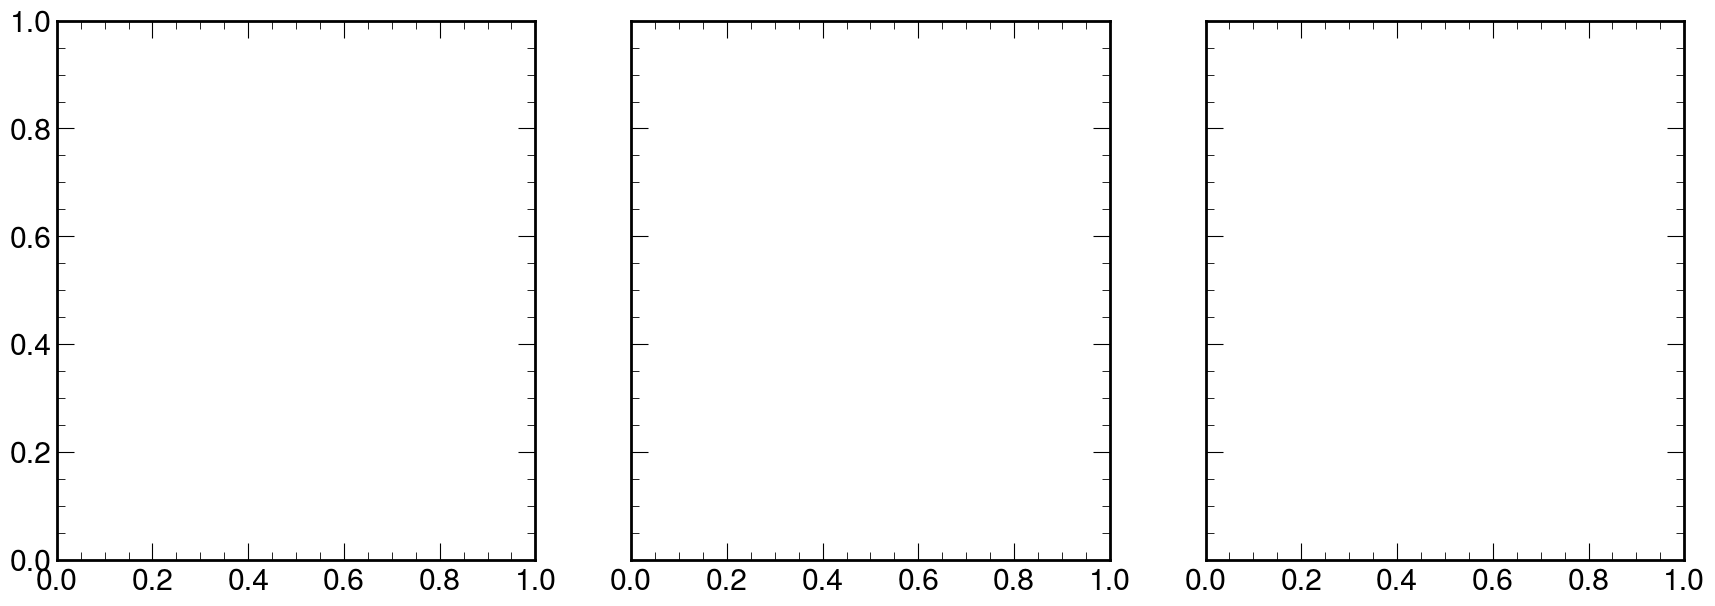

In [451]:
f, reweighted_wts, reweighting_factors = evaluate_model_on_eft(model, X_test, y_test, w_test)

first_f = f[0]
first_reweighted_wts = reweighted_wts[0]
first_reweighting_factors = reweighting_factors[0]

mean_f, mean_reweighted_wts, mean_reweighting_factors = calc_mean(f, reweighted_wts, reweighting_factors)
std_f, std_reweighted_wts, std_reweighting_factors = calc_std(f, reweighted_wts, reweighting_factors)

plot_dist_f(mean_f, eft_indices=eft_test_idx, epoch=-1)
plot_dist_w(mean_reweighting_factors, eft_indices=eft_test_idx, epoch=-1)
plot_1d_dist(mean_reweighted_wts, std_reweighted_wts, eft_indices=eft_test_idx, target_indices=target_test_idx, epoch=-1)
plot_2d_dist(mean_reweighted_wts, std_reweighted_wts, eft_indices=eft_test_idx, target_indices=target_test_idx, epoch=-1)
plot_weights_in_1d_phasespace(mean_reweighting_factors, eft_indices=eft_test_idx)
plot_weights_in_2d_phasespace(mean_reweighting_factors, eft_indices=eft_test_idx)

In [ ]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : impressed_cattle_1724
COMET INFO:     url                   : https://www.comet.com/philiw/tthbb-reweighting/ba2bfc227b7d4421b3febac6cbe9a7c5
COMET INFO:   Metrics:
COMET INFO:     average_loss : 0.6949502229690552
COMET INFO:     loss         : 0.6949502229690552
COMET INFO:     test_size    : 20
COMET INFO:     train_size   : 20
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 2048
COMET INFO:     channels      : 20
COMET INFO:     hidden_dim    : 64
COMET INFO:     input_dim     : 15
COMET INFO:     learning_rate : 0.001
COMET INFO:     n_epochs      : 1
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     f